# Script to open BTV from NXCALS

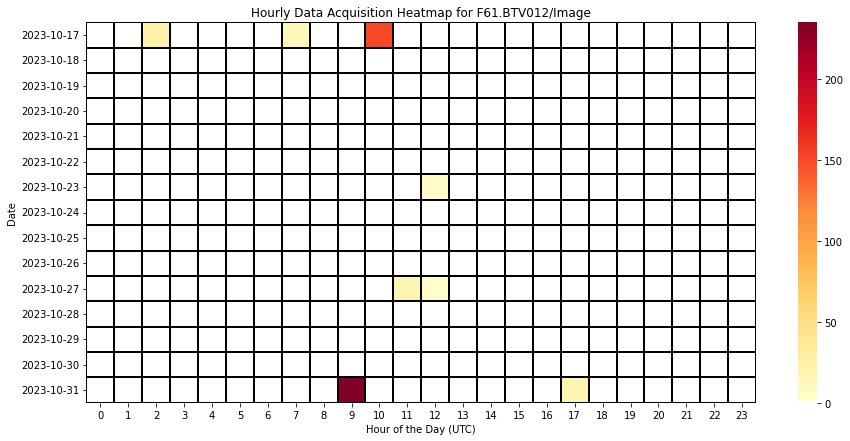

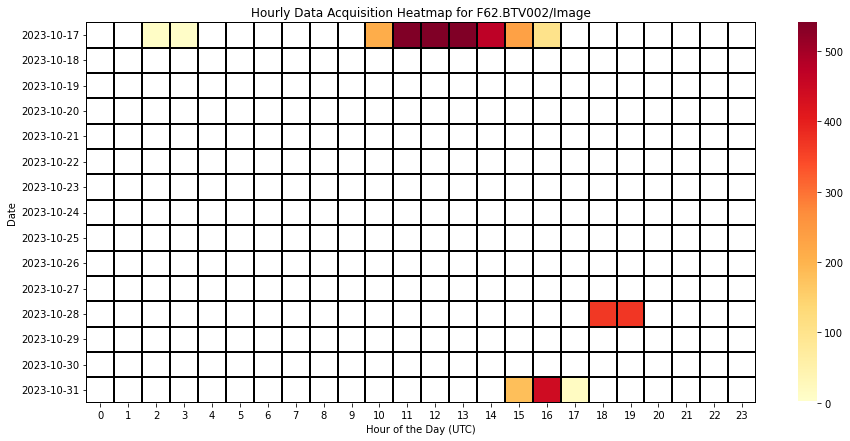

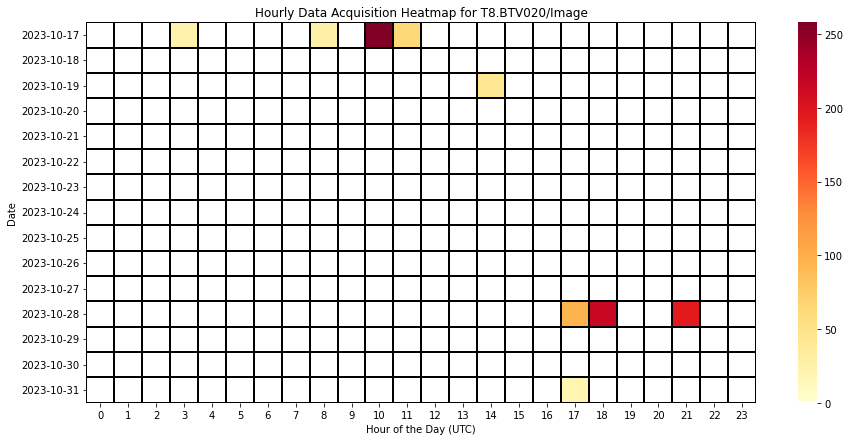

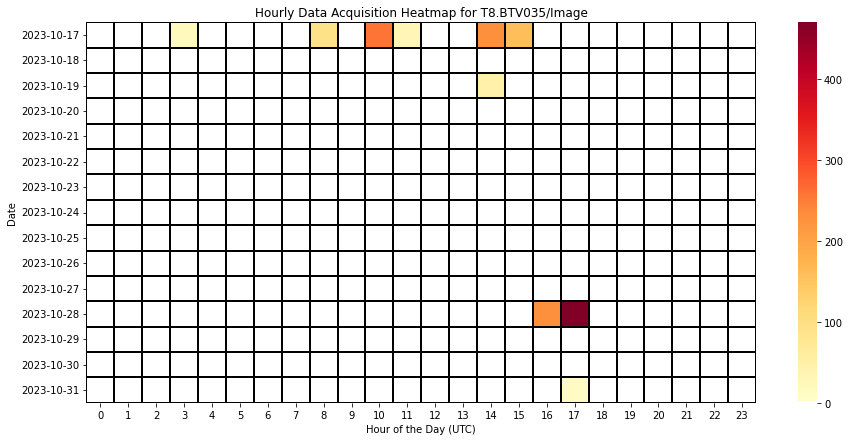

In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nxcals.api.extraction.data.builders import DevicePropertyDataQuery
from datetime import datetime
from matplotlib.colors import ListedColormap

# Function to process each BTV's data and return an hourly counts DataFrame
def process_dataframe(df):
    df["timestamp"] = pd.to_datetime(df["acqStamp"] / 1000000000, unit='s')
    df = df.set_index('timestamp')
    hourly_counts = df.resample('H').size()  # Resample by hour
    return hourly_counts

# Define the color for zero data ('white') and non-zero data ('YlOrRd')
zero_color = np.array([[1, 1, 1, 1]])  # RGBA for white color
non_zero_colors = plt.cm.YlOrRd(np.linspace(0, 1, 256))  # Get 256 colors from the 'YlOrRd' colormap

# Combine them to make a new 257-color colormap, first color is white for zero data
combined_colors = np.vstack((zero_color, non_zero_colors[1:]))  # Exclude the first color to keep it at 256
custom_cmap = ListedColormap(combined_colors)

# Build the query and load data into spark dataframe UTC Time
start = "2023-10-16 09:00:00.000"
end = "2023-11-02 18:00:00.000"

btv_list = [ "F61.BTV012/Image",
            "F62.BTV002/Image",
            "T8.BTV020/Image",
            "T8.BTV035/Image",
           ]

for btv in btv_list:
    df_big = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(btv).build()
    df = df_big.select('acqStamp').toPandas()

    hourly_counts = process_dataframe(df)

    # Pivot the data to create a matrix of day x hour
    hourly_counts.index = pd.to_datetime(hourly_counts.index)
    data_pivot = hourly_counts.groupby([hourly_counts.index.date, hourly_counts.index.hour]).sum().unstack(fill_value=0)

    # Plot the heatmap
    plt.figure(figsize=(15, 7))  # You can adjust the size as needed
    sns.heatmap(data_pivot, cmap=custom_cmap, linewidths=0.05, linecolor='black', annot=False)
    
    # Set the title and labels
    plt.title(f'Hourly Data Acquisition Heatmap for {btv}')
    plt.xlabel('Hour of the Day (UTC)')
    plt.ylabel('Date')

    # Save the heatmap to a file
    filename = f'heatmap_{btv.replace("/", "_")}.png'
    plt.savefig(filename)
    
    # Display the heatmap
    plt.show()

# Combining all the dataframes

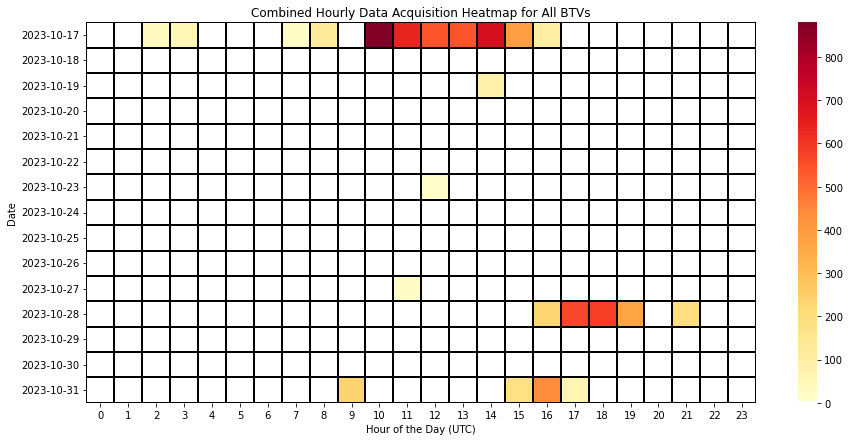

'combined_heatmap.png'

In [172]:
# Initialize an empty DataFrame to accumulate combined hourly counts for all BTVs
all_btv_hourly_counts = pd.DataFrame()

# Iterate through each BTV, process the data, and accumulate the hourly counts
for btv in btv_list:
    df_big = DevicePropertyDataQuery.builder(spark).system("CMW").startTime(start).endTime(end).entity().parameter(btv).build()
    df = df_big.select('acqStamp').toPandas()

    # Process the DataFrame to get hourly counts
    hourly_counts = process_dataframe(df)

    # Add the BTV's hourly counts to the combined DataFrame
    # The DataFrame index is the same for all since it's based on hourly resampling
    all_btv_hourly_counts[btv] = hourly_counts

# Sum the hourly counts across all BTVs
all_btv_hourly_counts['Total'] = all_btv_hourly_counts.sum(axis=1)

# Pivot the data to create a matrix of day x hour for the total counts
data_pivot = all_btv_hourly_counts['Total'].groupby([all_btv_hourly_counts.index.date, all_btv_hourly_counts.index.hour]).sum().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(15, 7))  # You can adjust the size as needed
sns.heatmap(data_pivot, cmap=custom_cmap, linewidths=0.05, linecolor='black', annot=False)

# Set the title and labels
plt.title('Combined Hourly Data Acquisition Heatmap for All BTVs')
plt.xlabel('Hour of the Day (UTC)')
plt.ylabel('Date')

# Save the heatmap to a file
filename = 'combined_heatmap.png'
plt.savefig(filename)

# Display the heatmap
plt.show()

# Return the path to the saved heatmap image file
filename